<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp8_tfidf_gpt_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q datasets rouge_score

In [2]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from rouge_score.rouge_scorer import RougeScorer
from itertools import cycle
from functools import partial
from textwrap import wrap
from IPython.display import HTML as html_print
pd.set_option('display.min_rows', 4)
tqdm.pandas()
tqdm = partial(tqdm, position=0, leave=True)
Ks = [1, 5, 10, 20, 40, 60, 80, 100]

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# Download preprocessed GPT embeddings
Please refer to exp7 for detail

In [4]:
# download df_sent (GPT's sentence embeddings)
!wget -O exp7_df_sent.230226.1803.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ERQRdKRJJ-dEpGMB0lCZkGUBZn69n5UUm4X3lnQoXMtZZw?download=1
df_sent = pd.read_pickle('exp7_df_sent.230226.1803.dfpkl')
display(df_sent)

# save them into a dict
sent_emb_dict = df_sent.set_index('sentence').embedding.to_dict()

--2023-02-28 01:21:15--  https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/ERQRdKRJJ-dEpGMB0lCZkGUBZn69n5UUm4X3lnQoXMtZZw?download=1
Resolving uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/chungyan_uoguelph_ca/Documents/Shared/exp7_df_sent.230226.1803.dfpkl?ga=1 [following]
--2023-02-28 01:21:15--  https://uoguelphca-my.sharepoint.com/personal/chungyan_uoguelph_ca/Documents/Shared/exp7_df_sent.230226.1803.dfpkl?ga=1
Reusing existing connection to uoguelphca-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 4820777861 (4.5G) [application/octet-stream]
Saving to: ‘exp7_df_sent.230226.1803.dfpkl’

exp7_df_sent.230226 100%[===================>]   4.49G  95.7MB/s    in 47s     

2023-02-28 01:22:03 (97.

,sentence,embedding
0,(CNN)The Palestinian Authority officially beca...,"[-0.0017101807752624154, -0.012141488492488861..."
1,The formal accession was marked with a ceremon...,"[0.007933792658150196, -0.010312643833458424, ..."
...,...,...
387370,Daily Mail Australia has contacted the Kidman ...,"[-0.022104516625404358, -0.010163666680455208,..."
387371,"Tribute: A good friend of Mr Hawley, Merivale ...","[-0.025303861126303673, -0.0009077293798327446..."


In [5]:
# download df_art (GPT's article and hightlights embeddings)
!wget -O exp7_df_art.230226.2119.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/Eav35id_qPpKmDNf7hMMehYBcecJsI8W0dWFjTZdxT34UA?download=1
df_art = pd.read_pickle('exp7_df_art.230226.2119.dfpkl')
display(df_art)

# save them into a dict
art_emb_dict  = df_art.set_index('article').article_emb.to_dict()
hl_emb_dict   = df_art.set_index('highlights').highlights_emb.to_dict()

--2023-02-28 01:22:30--  https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/Eav35id_qPpKmDNf7hMMehYBcecJsI8W0dWFjTZdxT34UA?download=1
Resolving uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/chungyan_uoguelph_ca/Documents/Shared/exp7_df_art.230226.2119.dfpkl?ga=1 [following]
--2023-02-28 01:22:31--  https://uoguelphca-my.sharepoint.com/personal/chungyan_uoguelph_ca/Documents/Shared/exp7_df_art.230226.2119.dfpkl?ga=1
Reusing existing connection to uoguelphca-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 379829129 (362M) [application/octet-stream]
Saving to: ‘exp7_df_art.230226.2119.dfpkl’

exp7_df_art.230226. 100%[===================>] 362.23M  84.2MB/s    in 4.3s    

2023-02-28 01:22:36 (84.2 MB

,article,highlights,id,sentences,article_emb,highlights_emb
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[-0.0005382943199947476, -0.004374864976853132...","[0.007540947292000055, -0.019479140639305115, ..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[-0.0026572151109576225, 0.0016707092290744185...","[-0.013608395121991634, -0.010644521564245224,..."
...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[-0.017547674477100372, -0.007072787266224623,...","[-0.010509248822927475, 0.000893479329533875, ..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[-0.02470867522060871, -0.0030950969085097313,...","[-0.013881632126867771, 0.004332297015935183, ..."


# Download preprocessed CNN/DM dataset + TFIDF results
Please refer to exp6 for detail

In [6]:
# download df (TFIDF's results)
!wget -O exp6.230224.2044.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EXTc_XLPQe9Kv5pZcjnftZkBskNW2qIWfkVBoFB5haVHtw?download=1
df = (pd.read_pickle('exp6.230224.2044.dfpkl')
      .drop(columns=['raw_ROUGE', 'R1', 'R2', 'RL'])
      .rename(columns={f'top{K}%_f1': f'TFIDF_ROUGE_top{K}%_f1' for K in Ks})
      .rename(columns={
          'TFIDF_sim'    : 'TFIDF_s2a_sim',        # sentence-to-article similarity
          'ROUGE_mean'   : 'ROUGE_s2h_score',      # sentence-to-highlights similarity
          'rank_by_TFIDF': 'rank_by_TFIDF',
          'rank_by_ROUGE': 'rank_by_ROUGE',
      })
     )
df

--2023-02-28 01:22:36--  https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EXTc_XLPQe9Kv5pZcjnftZkBskNW2qIWfkVBoFB5haVHtw?download=1
Resolving uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/chungyan_uoguelph_ca/Documents/Shared/exp6.230224.2044.dfpkl?ga=1 [following]
--2023-02-28 01:22:37--  https://uoguelphca-my.sharepoint.com/personal/chungyan_uoguelph_ca/Documents/Shared/exp6.230224.2044.dfpkl?ga=1
Reusing existing connection to uoguelphca-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 170303367 (162M) [application/octet-stream]
Saving to: ‘exp6.230224.2044.dfpkl’

exp6.230224.2044.df 100%[===================>] 162.41M  68.7MB/s    in 2.4s    

2023-02-28 01:22:39 (68.7 MB/s) - ‘exp6.230224.20

,article,highlights,id,sentences,TFIDF_s2a_sim,ROUGE_s2h_score,rank_by_TFIDF,rank_by_ROUGE,TFIDF_ROUGE_top1%_f1,TFIDF_ROUGE_top5%_f1,TFIDF_ROUGE_top10%_f1,TFIDF_ROUGE_top20%_f1,TFIDF_ROUGE_top40%_f1,TFIDF_ROUGE_top60%_f1,TFIDF_ROUGE_top80%_f1,TFIDF_ROUGE_top100%_f1
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,0.333333,0.333333,0.636364,0.750000,0.904762,1.0
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,0.000000,0.000000,0.500000,0.636364,0.866667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,0.800000,0.700000,0.684211,0.678571,0.810811,1.0
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,0.714286,0.769231,0.800000,0.729730,0.897959,1.0


# Merge GPT results into `df`

In [8]:
# function to convert sentence scores to rank
def cal_ranking(x):
    return np.argsort(np.argsort(x)) / (len(x)-1)

In [9]:
# calculate sentence-to-article based on GPT embeddings
df['GPT_s2a_sim'] = df.progress_apply(
    lambda x: (
        cosine_similarity(
            np.stack([art_emb_dict[x.article]]),
            np.stack([sent_emb_dict[sent] for sent in x.sentences])
        )[0]
    ),
    axis=1
)

# rank by sentence-to-article GPT embeddings
df['rank_by_GPT_s2a'] = df.GPT_s2a_sim.map(cal_ranking)
df

100%|██████████| 11490/11490 [00:20<00:00, 571.93it/s]


,article,highlights,id,sentences,TFIDF_s2a_sim,ROUGE_s2h_score,rank_by_TFIDF,rank_by_ROUGE,TFIDF_ROUGE_top1%_f1,TFIDF_ROUGE_top5%_f1,TFIDF_ROUGE_top10%_f1,TFIDF_ROUGE_top20%_f1,TFIDF_ROUGE_top40%_f1,TFIDF_ROUGE_top60%_f1,TFIDF_ROUGE_top80%_f1,TFIDF_ROUGE_top100%_f1,GPT_s2a_sim,rank_by_GPT_s2a
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,0.333333,0.333333,0.636364,0.750000,0.904762,1.0,"[0.9532745407644465, 0.8346857067550882, 0.929...","[1.0, 0.46153846153846156, 0.9615384615384616,..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,0.000000,0.000000,0.500000,0.636364,0.866667,1.0,"[0.8505145361905303, 0.9374876394910373, 0.893...","[0.7222222222222222, 1.0, 0.9444444444444444, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,0.800000,0.700000,0.684211,0.678571,0.810811,1.0,"[0.9049171842721291, 0.8334952351721436, 0.934...","[0.9347826086956522, 0.43478260869565216, 1.0,..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,0.714286,0.769231,0.800000,0.729730,0.897959,1.0,"[0.9490421925519402, 0.8413679378847979, 0.827...","[1.0, 0.7333333333333333, 0.6666666666666666, ..."


In [10]:
# calculate sentence-to-highlights based on GPT embeddings
df['GPT_s2h_sim'] = df.progress_apply(
    lambda x: (
        cosine_similarity(
            np.stack([hl_emb_dict[x.highlights]]),
            np.stack([sent_emb_dict[sent] for sent in x.sentences])
        )[0]
    ),
    axis=1
)

# rank by sentence-to-highlights GPT embeddings
df['rank_by_GPT_s2h'] = df.GPT_s2h_sim.map(cal_ranking)
df

100%|██████████| 11490/11490 [00:10<00:00, 1104.70it/s]


,article,highlights,id,sentences,TFIDF_s2a_sim,ROUGE_s2h_score,rank_by_TFIDF,rank_by_ROUGE,TFIDF_ROUGE_top1%_f1,TFIDF_ROUGE_top5%_f1,TFIDF_ROUGE_top10%_f1,TFIDF_ROUGE_top20%_f1,TFIDF_ROUGE_top40%_f1,TFIDF_ROUGE_top60%_f1,TFIDF_ROUGE_top80%_f1,TFIDF_ROUGE_top100%_f1,GPT_s2a_sim,rank_by_GPT_s2a,GPT_s2h_sim,rank_by_GPT_s2h
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,0.333333,0.333333,0.636364,0.750000,0.904762,1.0,"[0.9532745407644465, 0.8346857067550882, 0.929...","[1.0, 0.46153846153846156, 0.9615384615384616,...","[0.8843568613027442, 0.7962693570747013, 0.901...","[0.9230769230769231, 0.34615384615384615, 0.96..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,0.000000,0.000000,0.500000,0.636364,0.866667,1.0,"[0.8505145361905303, 0.9374876394910373, 0.893...","[0.7222222222222222, 1.0, 0.9444444444444444, ...","[0.7587715514869554, 0.8652437254432375, 0.896...","[0.05555555555555555, 0.8888888888888888, 1.0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,0.800000,0.700000,0.684211,0.678571,0.810811,1.0,"[0.9049171842721291, 0.8334952351721436, 0.934...","[0.9347826086956522, 0.43478260869565216, 1.0,...","[0.8597904343443625, 0.8216106618437409, 0.920...","[0.782608695652174, 0.4782608695652174, 1.0, 0..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,0.714286,0.769231,0.800000,0.729730,0.897959,1.0,"[0.9490421925519402, 0.8413679378847979, 0.827...","[1.0, 0.7333333333333333, 0.6666666666666666, ...","[0.9412313867552713, 0.7780387174048259, 0.825...","[1.0, 0.38333333333333336, 0.6833333333333333,..."


In [11]:
# calculate top-K% F1 score of various combinations

def cal_topKpctF1(true_rank_by, pred_rank_by, K):
    true = true_rank_by >= (1-K/100)
    pred = pred_rank_by >= (1-K/100)
    return f1_score(true, pred)

def append_topKpct_f1(df, K, true_rank_by, pred_rank_by, outp_prefix):
    df[f'{outp_prefix}_top{K}%_f1'] = df.progress_apply(
        lambda x: cal_topKpctF1(x[true_rank_by], x[pred_rank_by], K),
        axis=1
    )

for K in Ks:
    # predict by GPT, validate by ROUGE
    append_topKpct_f1(df, K,
                      true_rank_by='rank_by_ROUGE',
                      pred_rank_by='rank_by_GPT_s2a',
                      outp_prefix='GPT_ROUGE')
    
    # predict by GPT (sentence-to-article), validate by GPT (sentence-to-highlights)
    append_topKpct_f1(df, K,
                      true_rank_by='rank_by_GPT_s2h',
                      pred_rank_by='rank_by_GPT_s2a',
                      outp_prefix='GPT_GPT')
    
    # predict by TFIDF, validate by GPT
    append_topKpct_f1(df, K,
                      true_rank_by='rank_by_GPT_s2h',
                      pred_rank_by='rank_by_TFIDF',
                      outp_prefix='TFIDF_GPT')
df

100%|██████████| 11490/11490 [00:08<00:00, 1370.28it/s]


,article,highlights,id,sentences,TFIDF_s2a_sim,ROUGE_s2h_score,rank_by_TFIDF,rank_by_ROUGE,TFIDF_ROUGE_top1%_f1,TFIDF_ROUGE_top5%_f1,...,TFIDF_GPT_top40%_f1,GPT_ROUGE_top60%_f1,GPT_GPT_top60%_f1,TFIDF_GPT_top60%_f1,GPT_ROUGE_top80%_f1,GPT_GPT_top80%_f1,TFIDF_GPT_top80%_f1,GPT_ROUGE_top100%_f1,GPT_GPT_top100%_f1,TFIDF_GPT_top100%_f1
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,...,0.727273,0.812500,0.875000,0.875000,0.857143,0.952381,0.904762,1.0,1.0,1.0
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,...,0.500000,0.636364,0.909091,0.636364,0.866667,0.933333,0.933333,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,...,0.736842,0.714286,0.964286,0.821429,0.837838,0.972973,0.945946,1.0,1.0,1.0
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,...,0.880000,0.783784,0.864865,0.837838,0.857143,0.938776,0.938776,1.0,1.0,1.0


# Analysis

## Correltation between `TFIDF_sim` and `ROUGE_score`

In [ ]:
# function to create joint plot between two scores (or similarities)
def joint_plot_scores(score_x, score_y):
    data = pd.DataFrame({
        score_x: df[score_x].agg(np.concatenate),
        score_y: df[score_y].agg(np.concatenate),
    })
    sns.jointplot(
        data=data.sample(frac=0.1),
        x=score_x,
        y=score_y,
        marker='x',
        kind='reg',
        scatter_kws={'alpha': 0.1},
        line_kws={'color': 'black'},
    )
    plt.show()

TFIDF_s2a_sim vs ROUGE_s2h_score


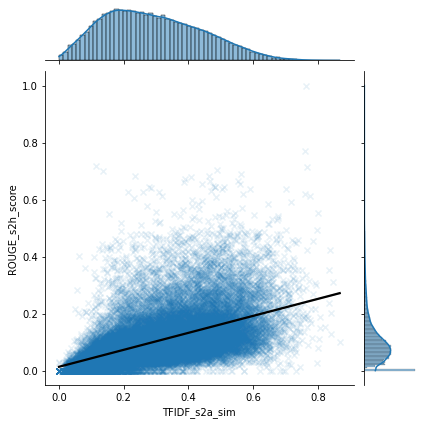

GPT_s2a_sim vs ROUGE_s2h_score


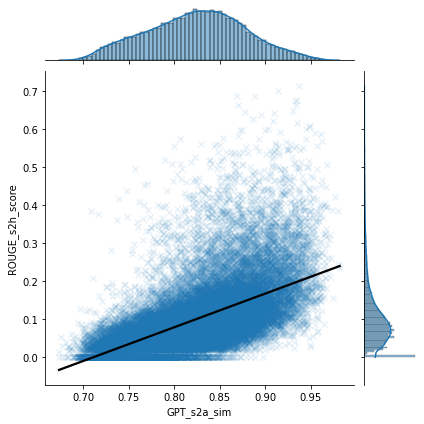

TFIDF_s2a_sim vs GPT_s2h_sim


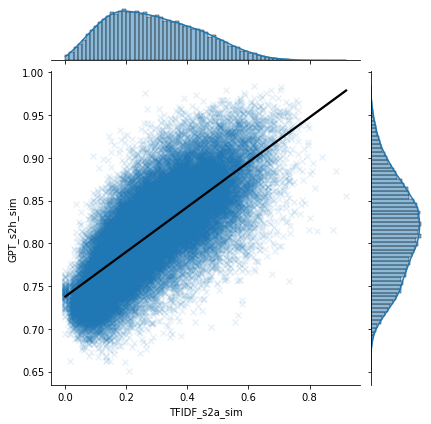

GPT_s2a_sim vs GPT_s2h_sim


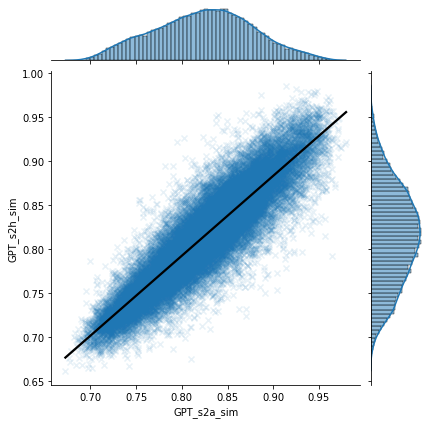

In [19]:
# joint plots of scores

for score_x, score_y in [('TFIDF_s2a_sim', 'ROUGE_s2h_score'),
                         ('GPT_s2a_sim'  , 'ROUGE_s2h_score'),
                         ('TFIDF_s2a_sim', 'GPT_s2h_sim'),
                         ('GPT_s2a_sim'  , 'GPT_s2h_sim'),
                         ]:
    print(score_x, 'vs', score_y)
    joint_plot_scores(score_x, score_y)

## Sample an `article` and check its result

In [35]:
# sample one article, re-run to sample another

x = df.sample(1).iloc[0]
x

article                   Finding the time to exercise when you've got h...
highlights                The Bike Washing Machine replaces the front wh...
id                                 0b12035e2daa266e40be6d9aa2bccfbfbb8ab4d0
sentences                 [Finding the time to exercise when you've got ...
TFIDF_s2a_sim             [0.20991908974032467, 0.6447799074740552, 0.25...
ROUGE_s2h_score           [0.06481481481481481, 0.2760141093474427, 0.11...
rank_by_TFIDF             [0.24, 0.96, 0.48, 0.8, 0.52, 0.08, 0.76, 0.36...
rank_by_ROUGE             [0.16, 0.96, 0.48, 0.84, 0.88, 0.08, 0.64, 0.3...
TFIDF_ROUGE_top1%_f1                                                    0.0
TFIDF_ROUGE_top5%_f1                                                    0.5
TFIDF_ROUGE_top10%_f1                                              0.666667
TFIDF_ROUGE_top20%_f1                                              0.833333
TFIDF_ROUGE_top40%_f1                                              0.909091
TFIDF_ROUGE_

In [36]:
# show the rank of the scores

SHOW_ABOVE = 0.75
HIGHLIGHT_ABOVE = 0.9
RANK_BY_1 = 'rank_by_GPT_s2a'
RANK_BY_2 = 'rank_by_ROUGE'

data = pd.DataFrame({
    RANK_BY_1 : x[RANK_BY_1].round(2),
    RANK_BY_2 : x[RANK_BY_2].round(2),
    'sentence': x.sentences,
})

(data
 .query(f'{RANK_BY_1}>{SHOW_ABOVE} or {RANK_BY_2}>{SHOW_ABOVE}')
 .style
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='yellow',
                    subset=[RANK_BY_1])
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='#FF8888',
                    subset=[RANK_BY_2])
 .set_properties(**{'text-align': 'left'})
)

,rank_by_GPT_s2a,rank_by_ROUGE,sentence
1,0.960000,0.960000,Chinese designers have developed an contraption called the Bike Washing Machine that contains a washing machine drum in its front wheel.
2,0.760000,0.480000,"When ridden, the pedalling motion causes the drum to rotate, churning your clothes inside like a traditional washer."
3,1.000000,0.840000,Chinese designers have developed a washing machine so cyclists can clean clothes while exercising (above) A generator inside the bike also creates electricity which can be stored for future use.
4,0.200000,0.880000,"The designers, based at Dalian Nationalities University, do not say whether the bike will automatically fill and drain with water too."
8,0.920000,1.000000,By changing the front wheel of the exercise bike into a washing machine drum it will spin as the user pedals .
13,0.800000,0.560000,"They said: 'Riding a bike is a popular exercise, washing laundry is something that you might do on daily basis or at least once a week, unless you keep buying new clothes and underwear, so why not combine them into a single useful equipment/appliance?"
14,0.440000,0.800000,The designers say the device is perfect for those struggling to find space for both a washing machine and an exercise bike . '
15,0.880000,0.920000,"Bike Washing Machine combines a stationary bicycle and washing machine, you can exercise while at the same time simultaneously washing your clothes. '"
16,0.840000,0.720000,"When you ride this bike, the pedalling motion causes the drum of the washing machine to rotate, at the same time, the superfluous electricity is generated which can be used to power the display screen or stored for future use.'"
21,0.720000,0.760000,"If cycling and doing your washing at the same time does not appeal, then perhaps another device that combines a treadmill with a washing machine."


In [39]:
# show the text

html_str = ''
for rank_t, rank_r, sent in zip(x[RANK_BY_1], x[RANK_BY_2], x.sentences):
    if (rank_t > HIGHLIGHT_ABOVE and rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style="background-color:yellow;color:#FF2222;"> {sent} </span>'
    elif (rank_t > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:yellow> {sent} </span>'
    elif (rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:#FF8888> {sent} </span>'
    else:
        html_str += f'{sent} '

html_str += (
    f'<br>'
    f'(<span style=background-color:yellow> <b> {RANK_BY_1} </b> </span>, '
    f'<span style=background-color:#FF8888> <b> {RANK_BY_2} </b> </span>, '
    f'<span style=background-color:yellow;color:#FF2222;"> <b> both AGREE </b> </span>)'
)

html_print(html_str)

## Top-K%-sentence F1 scores
Assume that we are to predict the top-K%-sentence using TFIDF_s2a_sim (or GPT_s2a_sim), while ROUGE_s2h_score (or GPT_s2h_sim) is the ground-truth.  E.g., for an article of 20 sentences, "top-10%-sentence" are the most important 2 key-sentences.

In short, here we evaluate if our method can find most importance sentences in each article.

TFIDF_ROUGE


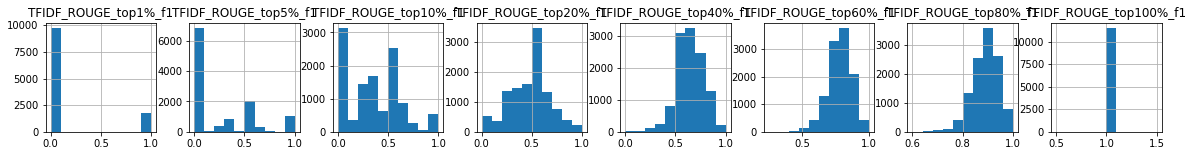

,TFIDF_ROUGE_top1%_f1,TFIDF_ROUGE_top5%_f1,TFIDF_ROUGE_top10%_f1,TFIDF_ROUGE_top20%_f1,TFIDF_ROUGE_top40%_f1,TFIDF_ROUGE_top60%_f1,TFIDF_ROUGE_top80%_f1,TFIDF_ROUGE_top100%_f1
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.0
mean,0.153119,0.231176,0.337547,0.468981,0.644056,0.778580,0.888360,1.0
std,0.359580,0.322287,0.272240,0.204638,0.136107,0.091775,0.054795,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.600000,1.0
25%,0.000000,0.000000,0.000000,0.333333,0.565217,0.725000,0.857143,1.0
50%,0.000000,0.000000,0.333333,0.500000,0.653846,0.785714,0.891892,1.0
75%,0.000000,0.500000,0.500000,0.600000,0.733333,0.842105,0.923077,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


GPT_ROUGE


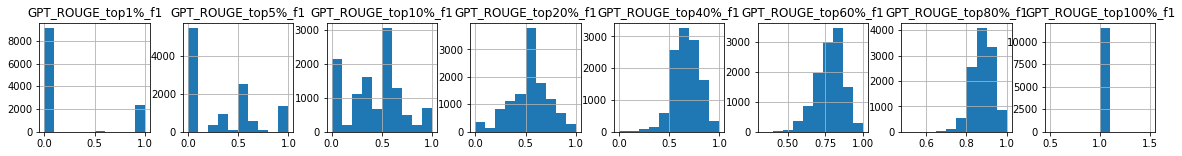

,GPT_ROUGE_top1%_f1,GPT_ROUGE_top5%_f1,GPT_ROUGE_top10%_f1,GPT_ROUGE_top20%_f1,GPT_ROUGE_top40%_f1,GPT_ROUGE_top60%_f1,GPT_ROUGE_top80%_f1,GPT_ROUGE_top100%_f1
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.0
mean,0.206861,0.309446,0.416143,0.531704,0.671043,0.779134,0.878671,1.0
std,0.404299,0.345904,0.275087,0.197678,0.131913,0.088588,0.053430,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.500000,1.0
25%,0.000000,0.000000,0.250000,0.400000,0.600000,0.727273,0.846154,1.0
50%,0.000000,0.250000,0.454545,0.533333,0.666667,0.785714,0.882353,1.0
75%,0.000000,0.500000,0.600000,0.666667,0.750000,0.840000,0.914286,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


TFIDF_GPT


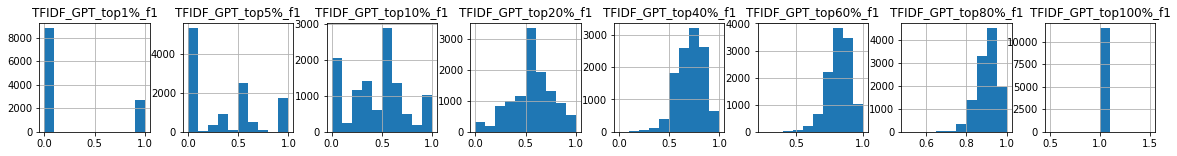

,TFIDF_GPT_top1%_f1,TFIDF_GPT_top5%_f1,TFIDF_GPT_top10%_f1,TFIDF_GPT_top20%_f1,TFIDF_GPT_top40%_f1,TFIDF_GPT_top60%_f1,TFIDF_GPT_top80%_f1,TFIDF_GPT_top100%_f1
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.0
mean,0.233261,0.329795,0.435596,0.555941,0.710090,0.818943,0.902243,1.0
std,0.422413,0.361652,0.290496,0.211232,0.134962,0.089575,0.053781,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.500000,1.0
25%,0.000000,0.000000,0.250000,0.428571,0.625000,0.769231,0.871795,1.0
50%,0.000000,0.333333,0.500000,0.571429,0.718750,0.823529,0.905660,1.0
75%,0.000000,0.500000,0.666667,0.692308,0.800000,0.875000,0.937500,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


GPT_GPT


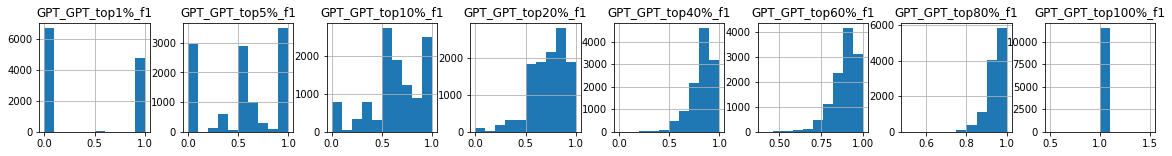

,GPT_GPT_top1%_f1,GPT_GPT_top5%_f1,GPT_GPT_top10%_f1,GPT_GPT_top20%_f1,GPT_GPT_top40%_f1,GPT_GPT_top60%_f1,GPT_GPT_top80%_f1,GPT_GPT_top100%_f1
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.0
mean,0.415463,0.534978,0.635057,0.724418,0.825614,0.892934,0.944512,1.0
std,0.492141,0.381683,0.277748,0.191210,0.118204,0.077444,0.046889,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,0.500000,1.0
25%,0.000000,0.000000,0.500000,0.625000,0.762218,0.857143,0.921053,1.0
50%,0.000000,0.500000,0.666667,0.750000,0.846154,0.903226,0.950000,1.0
75%,1.000000,1.000000,0.833333,0.850000,0.900000,0.942308,0.977273,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [46]:
for test_prefix in ['TFIDF_ROUGE', 'GPT_ROUGE', 'TFIDF_GPT', 'GPT_GPT']:
    print(test_prefix)
    cols = [f'{test_prefix}_top{K}%_f1'  for K in Ks]
    df[cols].hist(figsize=(20,2), layout=(1,8))
    plt.show()
    display(df[cols].describe())

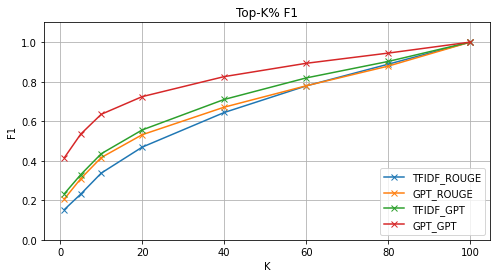

In [47]:
plt.figure(figsize=(8,4))

for test_prefix in ['TFIDF_ROUGE', 'GPT_ROUGE', 'TFIDF_GPT', 'GPT_GPT']:
    cols = [f'{test_prefix}_top{K}%_f1'  for K in Ks]
    plt.plot(Ks, df[cols].describe().T['mean'].values, 'x-', label=test_prefix)

plt.ylim(0,1.1)
plt.xlabel('K')
plt.ylabel('F1')
plt.title('Top-K% F1')
plt.grid()
plt.legend()
plt.show()